# 결정 트리
* 트리 기반의 분류 규칙


* 많은 규칙이 존재 -> 분류를 결정하는 방식이 복잡 -> 과적합 발생
         트리의 깊이가 깊어질 수록 결정트리의 예측 성능이 저해될 가능성이 높음.
         
         

* 정보 균일도가 데이터 세트로 쪼개질 수 있도록 조건을 찾아 서브 데이터를 만듦.


* 서브 데이터 세트에서 균일도가 높은 자식 데이터 세트를 쪼개는 방식으로 데이터 값 예측 


##### 결정 트리의 구조
         규칙 노드 : 규칙 조건 표시
         리프 노드 : 결정된 클래스 값 표시


##### 높은 정확도

적은 결정 노드로 높은 정확도를 가지려면 데이터를 분류할 때 최대한 많은 데이터 세트가 해당 분류에 속할 수 있도록 규칙이 정해져야 한다.

--> 최대한 균일한 데이터 세트를 구성하도록 분할.


##### 정보의 균일도

* 정보 이득 : (1 - 엔트로피), 정보 이득이 높은 속성을 기준으로 분할
        엔트로피는 주어진 데이터 집합의 혼잡도를 의미하는데,
        서로 다른 값이 섞여 있으면 엔트로피가 높고, 같은 값이 섞여 있으면 엔트로피가 낮다.

* 지니 계수 : 지니 계수가 낮을수록 데이터의 균일도가 높은 것으로 해석해 낮은 속성을 기준으로 분할


##### 장점
* 쉽다. 직관적이다
* 피처의 스케일링이나 정규화 등의 사전 가공 영향도가 크지 않다.

##### 단점
* 과적합으로 알고리즘 성능이 떨어진다.
* 이를 극복하기 위해 트리의 크기를 사전에 제한하는 튜닝이 필요하다.

### 결정 트리 실습 : 사용자 행동 인식 데이터

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
workspace_path = 'C:\\Users\\dbswj\\OneDrive\\바탕 화면\\human_activity'

In [165]:
feature_name_df = pd.read_csv('C:\\Users\\dbswj\\OneDrive\\바탕 화면\\human_activity\\features.txt', sep = ' ', header = None,
                            names = ['column_index','column_name'])
feature_name = feature_name_df.iloc[:,1].values.tolist()

In [140]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())

column_index    42
dtype: int64


##### 중복된 피처명을 고려해 새로운 피처명을 가지는 DataFrame을 반환하는 함수

In [138]:
def get_new_feature_name_df(x):
    feature_dup_df = pd.DataFrame(data = x.groupby('column_name').cumcount(),columns = ['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(x.reset_index(), feature_dup_df, how = 'outer')

    for i in new_feature_name_df['index']:
        if new_feature_name_df.iloc[i,3] == 1:
            new_feature_name_df.iloc[i,2] = new_feature_name_df.iloc[i,2] + '_1'
        elif new_feature_name_df.iloc[i,3] == 2:
            new_feature_name_df.iloc[i,2] = new_feature_name_df.iloc[i,2] + '_2'
    # new_feature_name_df['column_name'] = new_feature_name_df['column_name','dup_cnt'].apply(lambda x: x[0] + '_' + x[1] if x[1] > 0 else x[0], axis = 1)    

    new_feature_name_df = new_feature_name_df.iloc[:,2].values.tolist()

    return new_feature_name_df

##### human_ activity data의 train, test 생성 함수

In [180]:
def get_human_dataset():
    data_path_train = os.path.join(workspace_path,'train')
    data_path_test = os.path.join(workspace_path,'test')
    feature_name_df = pd.read_csv(os.path.join(workspace_path,'features.txt'), sep = ' ', names = ['column_index','column_name'])
    feature_name = get_new_feature_name_df(feature_name_df)
    
    X_train = pd.read_csv(os.path.join(data_path_train,'X_train.txt'), sep = '\s+', names = feature_name)
    X_test = pd.read_csv(os.path.join(data_path_test,'X_test.txt'), sep = '\s+', names = feature_name)
    y_train = pd.read_csv(os.path.join(data_path_train,'y_train.txt'), sep = '\s+', names = ['action'])
    y_test = pd.read_csv(os.path.join(data_path_test,'y_test.txt'), sep = '\s+', names = ['action'])
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

##### DecisionTreeClassifier

In [177]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [184]:
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train,y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(f'예측 정확도 : {accuracy:.4f}')

예측 정확도 : 0.8548


##### Parameter 조절

In [187]:
from sklearn.model_selection import GridSearchCV

In [202]:
params = {
    'max_depth' : [6, 8, 10, 12, 16, 20, 24],
    'min_samples_split' : [16,24]
}
grid_cv = GridSearchCV(dt_clf, param_grid = params, scoring = 'accuracy', cv = 5, verbose=1)
grid_cv.fit(X_train, y_train)
print(f'최고 평균 정확도 : {grid_cv.best_score_: .4f}')
print(f'최고 파라미터 : {grid_cv.best_params_}')

최고 평균 정확도 :  0.8549
최고 파라미터 : {'max_depth': 8, 'min_samples_split': 16}


In [203]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy1 = accuracy_score(y_test, pred1)
print(f'트리 예측 정확도 : {accuracy1:.4f}')

트리 예측 정확도 : 0.8717


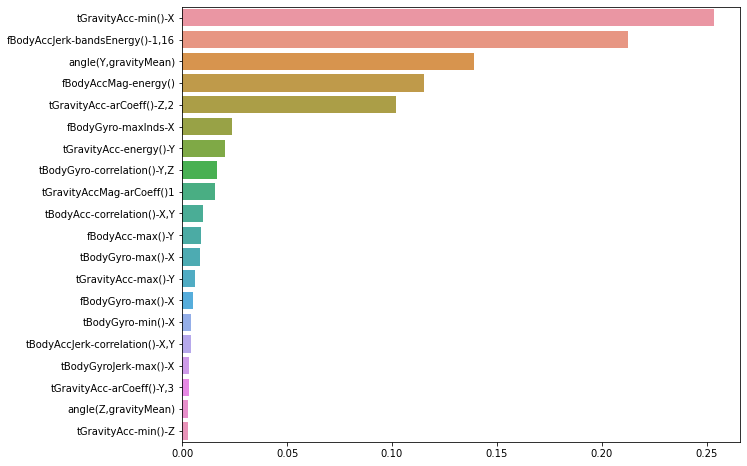

In [210]:
import seaborn as sns

ftr_importance_values = best_df_clf.feature_importances_
ftr_importance = pd.Series(ftr_importance_values, index = X_train.columns)
ftr_top20 = ftr_importance.sort_values(ascending = False)[:20]
plt.figure(figsize=(10,8))
sns.barplot(x = ftr_top20, y = ftr_top20.index)
plt.show()